## Setup

In [59]:
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.util import minibatch, compounding
import random
from math import isclose
%matplotlib inline

In [5]:
reviews = pd.read_csv("Yelp_restaurant_reviews.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
review_id        100000 non-null object
stars            100000 non-null int64
text             100000 non-null object
review_length    100000 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [6]:
reviews.head()

,review_id,stars,text,review_length
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570


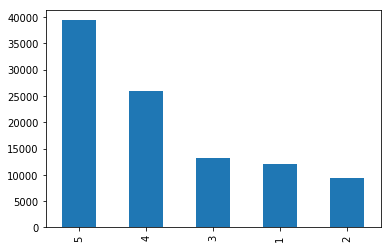

In [12]:
ax = reviews['stars'].value_counts().plot(kind='bar')

In [10]:
# to deal with the unbalanced data, put ratings 4-5 as positive and ratings 1-3 as negative
reviews['is_positive'] = reviews['stars'] > 3
reviews.head()

,review_id,stars,text,review_length,is_positive
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300,True
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190,True
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252,False
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326,True
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570,True


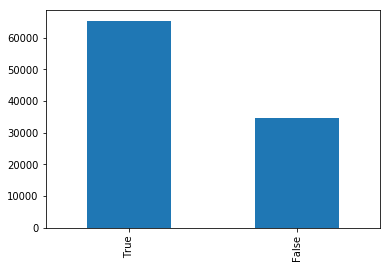

In [13]:
ax = reviews['is_positive'].value_counts().plot(kind='bar')

In [18]:
# TODO (maybe): normalize so we take the same number of positive reviews and negative reviews

## Spacy text categorizer

In [23]:
reviews['tuples'] = reviews.apply(
    lambda row: (row['text'], row['is_positive']), axis=1)
train = reviews['tuples'].tolist()

In [25]:
train[:3]

[('The best service I had was here during my time in Las Vegas. The al a cart sides were large enough to share family style. My filet was overcooked and the server had another one out to me in minutes. The martinis were wonderful in chilled glasses with blue cheese olives. The table settings beautiful.',
  True),
 ("What a fun place. Valet parking, a great outside covered patio shared by 4 great restos! Had lunch at Bario which was good and then played some ping pong in the yard. Can't wait to go again!",
  True),
 ('My boyfriend and I dropped in for the first time on a Sunday afternoon.  The atmosphere was nice and the restaurant was very clean.  Our server Dan was knowledgeable and pleasant. The food was average but good for the price. We will definately be back.',
  False)]

In [27]:
train[-2:]

[('Super!\nMy 1st good meal in Phoenix !\nSigh ...come with family so Chinese food everyday..sucks...\n\nGood as it said ..highly recommend...\n\nThe braised short rib pizza\nPB&J smoothie',
  True),
 ('12 of us went on a Friday night. There was a large variety of food ordered and everyone enjoyed their meals. I would give 5 stars but the server was not very attentive. Wine is included. Overall an awesome value for Vegas!',
  True)]

In [ ]:
reviews['star_tuples'] = reviews.apply(lambda row: (row['text'], row['stars'].astype('str')) )

In [ ]:
def starcats_from_labels(labels, min_stars=1, max_stars=5):
#     cats = []
#     for y in labels:
#         c = dict()
#         for star in range(min_stars, max_stars + 1):
#             star = str(star)
#             if star == y:
#                 c[y] = True
#             else:
#                 c[y] = False
#         cats.append(c)
    return [
            {str(star): str(star) == y 
            for star in range(min_stars, max_stars + 1)}
            for y in labels
           ]

def poscats_from_labels(labels):
    return [{'POSITIVE': y, 'NEGATIVE': not y} for y in labels]

In [60]:
def load_data(train_list, limit=0, split=0.8, cat_function=poscats_from_labels):
    """
    Given a list of data, return training data and validation data.
    Limit is the total number of samples to use, and split is the percentage of samples to be used for training.
    
    Note: this assumes data is already shuffled (i.e., in random order)
    """
    train_data = train_list[-limit:]
    texts, labels = zip(*train_data)
    cats = cat_function(labels)
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    # true positives + true negatives + false positives + false negatives should equal the number of documents,
    # or we've done something wrong
    assert isclose(tp + fp + tn + fn, len(texts)), (tp + fp + tn + fn, len(texts))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score,
           'textcat_a': accuracy, 'textcat_tp': tp, 'textcat_tn': tn, 'textcat_fp': fp, 'textcat_fn': fn}

In [32]:
# ("Number of texts to train from","t" , int). In this case we will train from all the texts.
n_texts=len(train)
# ("Number of training iterations", "n", int))
n_iter=10

In [64]:
nlp = spacy.load("en_core_web_sm")

In [65]:
nlp = spacy.load("en_core_web_sm")
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
# use config options from spacy training tutorial
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat', config={"exclusive_classes": True, "architecture": "simple_cnn"})
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier.
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(train, limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 100000 examples (80000 training, 20000 evaluation)


In [ ]:
def prepare_training(train, n_texts=0, labels=("POSITIVE", "NEGATIVE"), cfg={"exclusive_classes": True, "architecture": "simple_cnn"}):
    if not n_texts:
        n_texts = len(train)
    nlp = spacy.load("en_core_web_sm")
    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # use config options from spacy training tutorial
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat', config=cfg)
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add labels to text classifier.
    for label in labels:
        textcat.add_label(label)

    # load the dataset
    print("Loading data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(train, limit=n_texts)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))
    return train_data, nlp

In [51]:
print(
    f"""Iteration: {1}, Loss: {20.2}
    {35.34032039:.3f}\t"""
)

Iteration: 1, Loss: 20.2
    35.340	


In [66]:
# get names of other pipes to disable them during training
# the last two are for if you are using transformers (see https://spacy.io/models/en-starters)
pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

metrics_dict = dict()

start = time.time()
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('Precision\tRecall\tF-score\taccuracy')
    batch_sizes = compounding(4.0, 32.0, 1.001)
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            train_scores = evaluate(nlp.tokenizer, textcat, train_texts, train_cats)
            dev_scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print(
                f"""Iteration: {i}, Loss: {losses['textcat']}
training:   {train_scores['textcat_p']:.3f}\t{train_scores['textcat_r']:.3f}\t{train_scores['textcat_f']}\t{train_scores['textcat_a']:.3f}
validation: {dev_scores['textcat_p']:.3f}\t{dev_scores['textcat_r']:.3f}\t{dev_scores['textcat_f']}\t{dev_scores['textcat_a']:.3f}
"""
            )
            metrics_dict[i] = {"loss": losses['textcat'], 'train': train_scores, 'validation': dev_scores}
end = time.time()
training_time = timedelta(seconds = end - start)
print("Training time:", training_time)

Training the model...
Precision	Recall	F-score	accuracy
Iteration: 0, Loss: 12.263682646431334
training:   0.925	0.948	0.9366794710860716	0.916
validation: 0.913	0.938	0.9254420841373387	0.902

Iteration: 1, Loss: 0.353853815502589
training:   0.935	0.955	0.9450256584727983	0.927
validation: 0.918	0.940	0.9290836653379942	0.907

Iteration: 2, Loss: 0.3204571801502425
training:   0.942	0.959	0.9507078933659925	0.935
validation: 0.923	0.940	0.9310764549251714	0.909

Iteration: 3, Loss: 0.2978772127007687
training:   0.947	0.964	0.9555479828096948	0.941
validation: 0.922	0.943	0.9325335054475378	0.911

Iteration: 4, Loss: 0.2797220430006746
training:   0.951	0.968	0.959432720800379	0.946
validation: 0.923	0.942	0.9324113825455986	0.911

Iteration: 5, Loss: 0.26377781663859423
training:   0.956	0.972	0.9638741470809463	0.952
validation: 0.921	0.942	0.9314600341743968	0.910

Iteration: 6, Loss: 0.24469582271404988
training:   0.962	0.974	0.9680438104456146	0.958
validation: 0.922	0.941	0.93

In [67]:
def do_training(train_data, n_iter=10):
    # get names of other pipes to disable them during training
    # the last two are for if you are using transformers (see https://spacy.io/models/en-starters)
    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

    metrics_dict = dict()

    start = time.time()
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('Precision\tRecall\tF-score\taccuracy')
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                train_scores = evaluate(nlp.tokenizer, textcat, train_texts, train_cats)
                dev_scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
                print(
                    f"""Iteration: {i}, Loss: {losses['textcat']}
    training:   {train_scores['textcat_p']:.3f}\t{train_scores['textcat_r']:.3f}\t{train_scores['textcat_f']}\t{train_scores['textcat_a']:.3f}
    validation: {dev_scores['textcat_p']:.3f}\t{dev_scores['textcat_r']:.3f}\t{dev_scores['textcat_f']}\t{dev_scores['textcat_a']:.3f}
    """
                )
                metrics_dict[i] = {"loss": losses['textcat'], 'train': train_scores, 'validation': dev_scores}
    end = time.time()
    training_time = timedelta(seconds = end - start)
    print("Training time:", training_time)
    return metrics_dict

In [ ]:
def plot_acc(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def plot_loss(history):
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def plot_metrics(history):
  plot_acc(history)
  plot_loss(history)